# Explaining Models with Shap

* Paul Montecinos
* 5/25/23

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
import sklearn
!python --version

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib, os

## setting random state for reproducibility
## Matplotlib style
fav_style = ('ggplot', 'seaborn-dark-palette')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

Python 3.9.15


C:\Users\paulm\AppData\Local\Temp\ipykernel_28620\3050121446.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(fav_style)


In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [3]:
## Load the joblib file stored in the models folder
fname = "./Models/regression.joblib"
loaded = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [4]:
## Saving the loaded objects as separate varaibles
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

In [5]:
X_train.head()

,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_size,outlet_location_type,outlet_type
4776,16.350,Low Fat,0.029565,Household,256.4646,Medium,2,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,Medium,2,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,Medium,0,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,Small,1,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,NaN,1,Supermarket Type1


In [6]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         index=X_train.index,
                         columns=feature_names)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        index=X_test.index,
                        columns=feature_names)
X_train_df.head()

,item_weight,item_visibility,item_mrp,outlet_location_type,item_fat_content_Low Fat,item_fat_content_Regular,item_type_Baking Goods,item_type_Breads,item_type_Breakfast,item_type_Canned,...,item_type_Snack Foods,item_type_Soft Drinks,item_type_Starchy Foods,outlet_size_High,outlet_size_Medium,outlet_size_Small,outlet_type_Grocery Store,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3
4776,0.827485,-0.712775,1.828109,1.084948,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7510,0.566644,-1.291052,0.603369,1.084948,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5828,-0.121028,1.813319,0.244541,-1.384777,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5327,-1.158464,-1.004931,-0.952591,-0.149914,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4810,1.538870,-0.965484,-0.336460,-0.149914,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [7]:
evaluate_regression(rf_reg, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,300.80,433.39
Test,0.54,783.74,"1,126.56"


In [8]:
# Import and init shap
import shap
shap.initjs()

In [9]:
# Take a sample of the training data
X_shap = shap.sample(X_train_df,nsamples = 500,random_state = 42)
y_shap = y_train.loc[X_shap.index]

# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values form the explainer
shap_values = explainer(X_shap,y_shap)

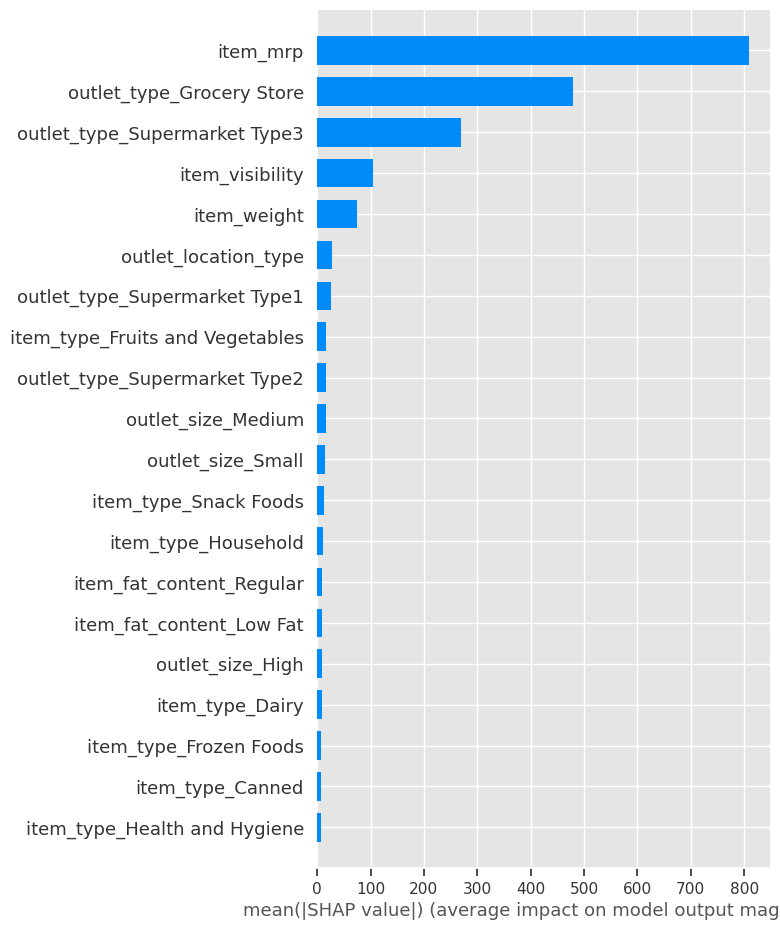

In [14]:
shap.summary_plot(shap_values, features = X_shap, plot_type='bar');

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


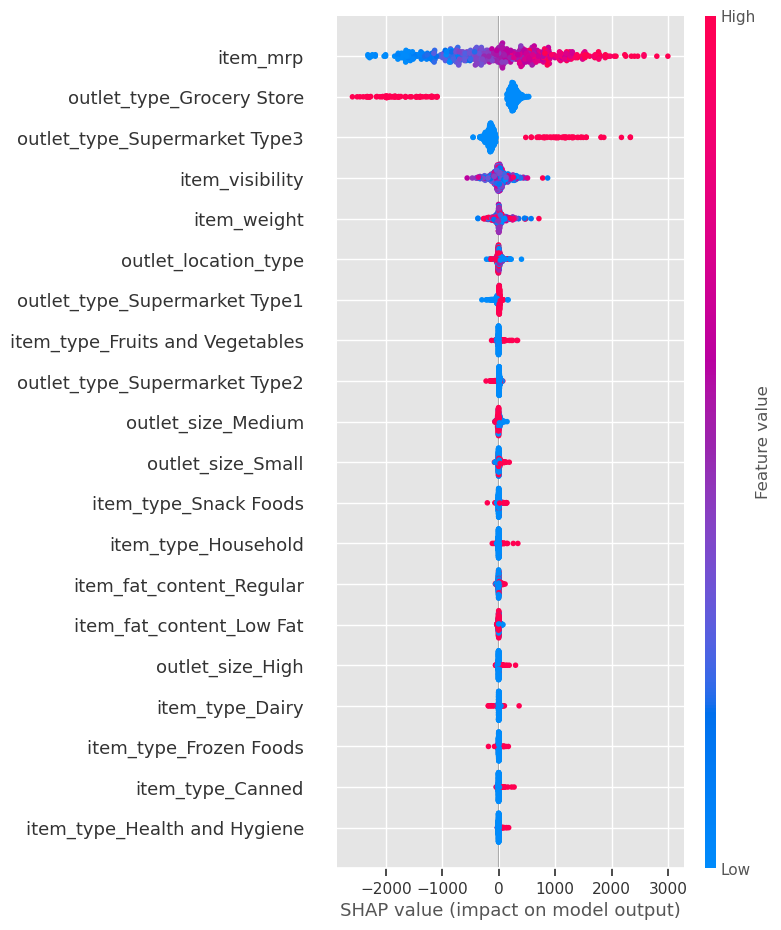

In [10]:
shap.summary_plot(shap_values, features = X_shap);